# Response to Reviewer 2: uncovering dimensions of the RDMs

Reviewer 2 asked us to investigate how the representations differ across ROIs, and suggested using PCA to recover the eigen-RDMs. Because participants saw different stimuli,  we lack correspondence between the rows and columns of the RDMs across subjects, so we cannot compare the eigen-RDMs across subjects.

Instead, we will perform model-based RSA within each ROI across subjects, using two model RDMs: Familiarity and Identity. In addition, we will control for low-level visual differences by performing Spearman partial correlation, introducing RDMs generated from C1 and C2 features extracted from the HMAX model (Riesenhuber & Poggio, 1999).

## Import and functions

In [1]:
%matplotlib inline
#import matplotlib
#matplotlib.use('svg')
import matplotlib.pyplot as plt

import sys
p = ['../']
for pp in p:
    if pp not in sys.path:
        sys.path.insert(1, pp)

from compute_dsmroi_firstlev import load_ds
import expdir
from mds_rois import bootstrap_mds, get_dsm_roi_xval1, dendrogram_dss_mvdoc, xboost, mdsf, \
                     plot_dsm, select_rois_pymvpa, get_minmax, mk_colorbar
from numpy.ma import masked_array
from mvpa2.suite import *
fns = expdir.expdir()
from scipy.spatial import distance as dist
from scipy.stats import scoreatpercentile
from matplotlib import cm
import mne

import seaborn as sns
from os.path import join as pjoin
import pandas as pd
from scipy.io import loadmat
from glob import glob
import re
from os.path import basename
from collections import defaultdict

In [2]:
img_dir = './img_response_reviewers'

In [3]:
def load_dsm(subnr):
    fn = pjoin(fns.mvpadir(subnr), 'roi_rsa_jimroi_5r_fisher_nooverlap/dsm_condition.hdf5')
    ds = h5load(fn)
    return ds

In [4]:
def make_ds_distance(ds, make_symmetric=False, rank=False):
    if rank:
        ds_ = np.apply_along_axis(rankdata, 1, ds)
    else:
        ds_ = ds.samples
    if make_symmetric:
        # add transpose and take only upper triangular with diagonal
        ds_new = []
        for row in ds_:
            tmp = row.reshape(8, 8)
            tmp += tmp.T
            tmp /= 2
            ds_new.append(tmp[np.triu_indices_from(tmp)])
        ds_ = np.array(ds_new)
        
    ds_dist = squareform(pdist(ds_, metric='correlation'))
    return Dataset(ds_dist, sa=ds.sa, fa={'roi': ds.sa.targets})

In [5]:
def make_symmetric(ds):
    """Given the cross-validated RDM in ds, it will create a symmetric version
    by adding the transpose and averaging."""
    # add transpose and take only upper triangular with diagonal
    ds_new = []
    for row in ds.samples:
        tmp = row.reshape(8, 8)
        tmp += tmp.T
        tmp /= 2
        ds_new.append(tmp[np.triu_indices_from(tmp)])
    return np.array(ds_new)    

## Load data

In [6]:
# this contains the first level
roi_rdm = [load_dsm(i) for i in range(1, 34)]
# this contains the second level for each subject
roi_dist = [make_ds_distance(ds, make_symmetric=True) for ds in roi_rdm]

`roi_rdm` contains the cross-validated RDMs within each ROI; they are correlation values, thus we need to convert them to distances

In [7]:
roi_rdm_sym = map(make_symmetric, roi_rdm)
roi_rdm_sym = map(lambda x: 1. - x, roi_rdm_sym)

### Setup model matrices

In [8]:
# make some model matrices
id_mat = np.ones((8, 8))
np.fill_diagonal(id_mat, 0.)

fam_mat = np.ones((8, 8))
fam_mat[:4, :4] = 0.
fam_mat[4:, 4:] = 0.

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


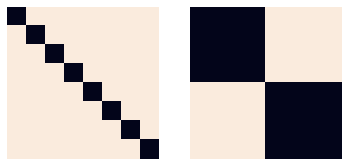

In [9]:
fig, axs = plt.subplots(1, 2)
sns.heatmap(id_mat, xticklabels=False, yticklabels=False, cbar=False, square=True, ax=axs[0]);
sns.heatmap(fam_mat, xticklabels=False, yticklabels=False, cbar=False, square=True, ax=axs[1]);

In [10]:
from partial_corr import partial_corr
from scipy.stats import rankdata
from sklearn.preprocessing import scale

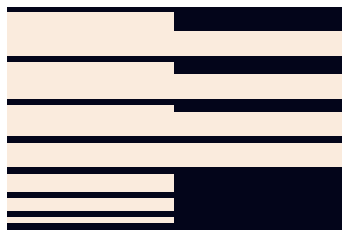

In [11]:
# prepare the predictors matrices
id_mat_triu = id_mat[np.triu_indices_from(id_mat)]
fam_mat_triu = fam_mat[np.triu_indices_from(fam_mat)]
models = np.hstack((id_mat_triu[:, None], fam_mat_triu[:, None]))
sns.heatmap(models, xticklabels=False, yticklabels=False, cbar=False);

In [12]:
# we're going to scale and rank to have spearman correlation, since
# partial_corr doesn't introduce an intercept
def scale_rank(x):
    return(scale(rankdata(x)))

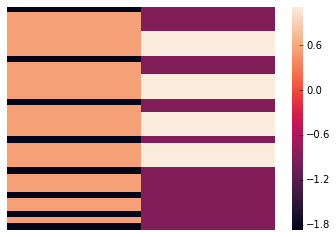

In [13]:
models_sr = np.apply_along_axis(scale_rank, 0, models)
sns.heatmap(models_sr, xticklabels=False, yticklabels=False);

In [14]:
def compute_corr(rdm, models):
    """perform partial correlation between rdm and some models"""
    x = np.hstack((
    scale_rank(rdm)[:, None], models))
    return partial_corr(x)[0, 1:]

In [15]:
def add_subject(df, subnr):
    """add subject variable to a dataframe"""
    df['subject'] = 'sub{0:02d}'.format(subnr)

In [16]:
def get_lowlevel_rdm(subj):
    """
    Given a subject id, it will load the C1 and C2 features from HMAX, and then
    return the RDMs obtained by averaging the features of the images for each identity.
    By default euclidean distance is used.
    
    Returns
    -------
    c1_dist, c2_dist: the (8, 8) dissimilarity matrices for each subject; the order reflects
        the order of the neural data (control first, then familiar)
    """
    # load c1 and c2 features
    c1c2 = loadmat('../../results/c1c2_subject_stimuli_lo/{0}/c1c2.mat'.format(subj))
    c1 = c1c2['c1']
    c2 = c1c2['c2']
    # each element is one image, with 8 scales, which are n x n x 4 matrices
    # we want to unroll everything
    c1_stacked = np.vstack([
                    np.hstack([a.flatten() for a in c1_img.flatten()]) 
                    for c1_img in c1.flatten()])
    c2_stacked = np.vstack(c2.reshape((-1)).tolist()).T
    assert(len(c1_stacked) == 24)
    assert(len(c2_stacked) == 24)

    # get labels id
    fns = np.loadtxt('../../results/c1c2_subject_stimuli_lo/{0}/imgorder.txt'.format(subj),
                    dtype=str)
    f = re.compile('(control[0-9]|friend[0-9])')

    identity = np.array([f.findall(s)[0] for s in fns])
    # average features within each identity
    unique_identity = np.unique(identity)
    
    # because matteo is becoming paranoid, load the data and check that the order
    # is really the same
    subj_nr = int(re.findall('s([0-9]*)', subj)[0])
    ds = load_ds(subj_nr)
    assert(np.array_equal(unique_identity, ds.sa.condition[:8]))
    del ds
    
    c1_avg = []
    c2_avg = []
    for id_ in unique_identity:
        c1_avg.append(c1_stacked[identity == id_].mean(axis=0))
        c2_avg.append(c2_stacked[identity == id_].mean(axis=0))
    c1_avg = np.array(c1_avg)
    c2_avg = np.array(c2_avg)

    # compute distance
    c1_dist = squareform(pdist(c1_avg))
    c2_dist = squareform(pdist(c2_avg))
    
    return c1_dist, c2_dist

In [17]:
subjs = sorted([basename(s) for s in glob('../../results/c1c2_subject_stimuli_lo/*')])

In [18]:
# add them in the format needed for predictors
c1_pred = []
c2_pred = []
for subj in subjs:
    c1_dist, c2_dist = get_lowlevel_rdm(subj)
    c1_pred.append(c1_dist[np.triu_indices_from(c1_dist)])
    c2_pred.append(c2_dist[np.triu_indices_from(c2_dist)])

In [19]:
# scale and rank
c1_pred = map(scale_rank, c1_pred)
c2_pred = map(scale_rank, c2_pred)

In [20]:
def stack_predictors(c1c2preds):
    """Add the c1 and c2 predictors"""
    return np.hstack((models_sr, c1c2preds[0][:, None], c1c2preds[1][:, None]))

models_all = map(stack_predictors, zip(c1_pred, c2_pred))

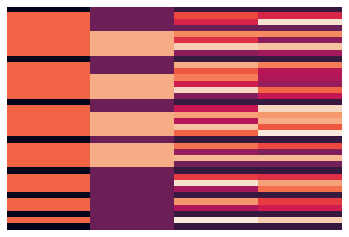

In [21]:
# let's check one of them
sns.heatmap(models_all[1], xticklabels=False, yticklabels=False, cbar=False);

In [22]:
# compute correlation between the neural rdm and the predictors for each roi
corrs = []
for rdm, model in zip(roi_rdm_sym, models_all):
    corr_ = []
    for roi in rdm:
        corr_.append(compute_corr(roi, model))
    corrs.append(np.array(corr_))

In [23]:
# make a dataframe
corr_rois_df = [
    pd.DataFrame(corr, index=roi_rdm[0].sa.targets, 
                 columns=['identity', 'familiarity', 'c1', 'c2']).reset_index()
    for corr in corrs
]
# add subject number
for subnr, corr in enumerate(corr_rois_df, 1):
    add_subject(corr, subnr)

# concatenate
corr_rois_df = pd.concat(corr_rois_df)
# finally make it long format to use seaborn plotting
corr_rois_df_long = pd.melt(corr_rois_df, value_vars=['identity', 'familiarity'], 
                            id_vars=['index', 'subject'])

In [24]:
# divide according to system
system2roi = {
    'early_visual': [ 'EV1 - L', 'EV2 - L', 'EV1 - R', 'EV2 - R'],
    'anterior_core_system': ['IFG1 - L', 'IFG2 - L', 'IFG2 - R'],
    'theory_of_mind': ['TPJ - L', 'MPFC - L', 'TPJ - R', 'MPFC - R'],
    'ventral_core_system': ['OccFus - L', 'pFus - L', 'mFus - L', 
                            'OccFus - R', 'pFus - R', 'mFus - R', 'aFus - R'],
    'dorsal_core_system': ['pMTG - L', 'mMTG - L', 'aMTG - L', 'pMTG - R',  'mMTG - R', 'aMTG - R'],
    'precuneus': ['dPreCun - L', 'mPreCun - L', 'vPreCun - L','dPreCun - R',  'mPreCun - R',  'vPreCun - R']
}

In [25]:
# have colors for each system too
system2color = dict(
    early_visual = '#0000FF',
    dorsal_core_system = '#b1551c',
    ventral_core_system = '#e41a1a',
    anterior_core_system = '#e4a11a',
    theory_of_mind = '#008100',
    precuneus = '#099997',
)

In [26]:
# add side and roi for plotting with factorplot
corr_rois_df_long['side'] = map(lambda x: x.split(' - ')[1], corr_rois_df_long['index'])
corr_rois_df_long['roi'] = map(lambda x: x.split(' - ')[0], corr_rois_df_long['index'])

In [27]:
# divide into systems
df_systems = dict()
for lbl, roi in system2roi.iteritems():
    df_systems[lbl] = corr_rois_df_long[np.in1d(corr_rois_df_long['index'], roi)]

In [28]:
sns.set_style('ticks')
sns.set_context('notebook')

In [29]:
# order them for plotting
system2order = {
    'early_visual': [ 'EV1', 'EV2'],
    'anterior_core_system': ['IFG1', 'IFG2'],
    'theory_of_mind': ['TPJ', 'MPFC'],
    'ventral_core_system': ['OccFus', 'pFus', 'mFus', 'aFus'],
    'dorsal_core_system': ['pMTG', 'mMTG', 'aMTG'],
    'precuneus': ['dPreCun', 'mPreCun', 'vPreCun']  
}

roi2system = dict()
for system, rois in system2order.iteritems():
    for roi in rois:
        roi2system[roi] = system

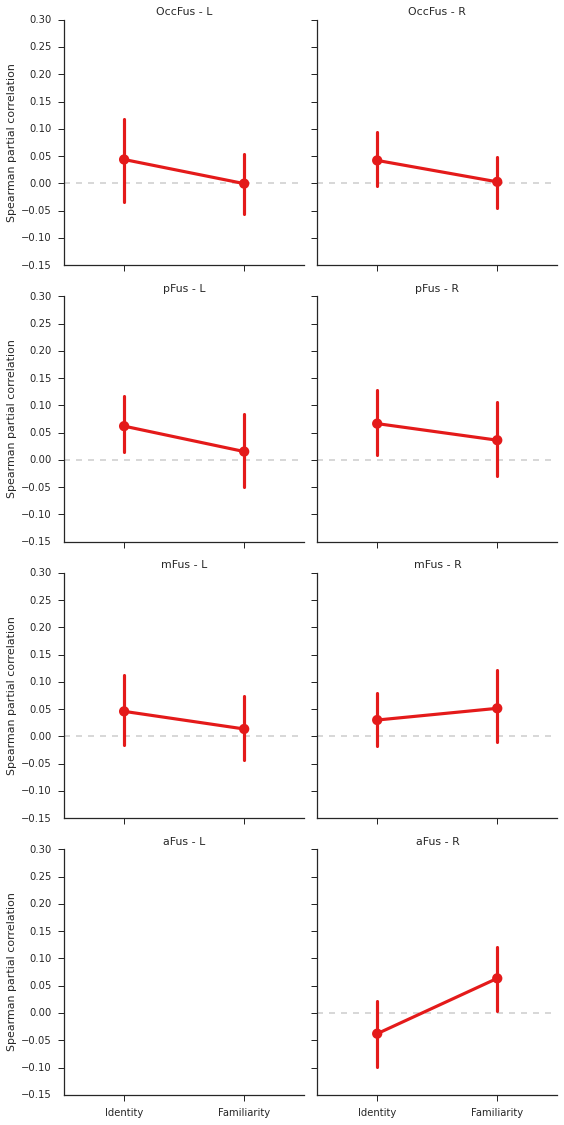

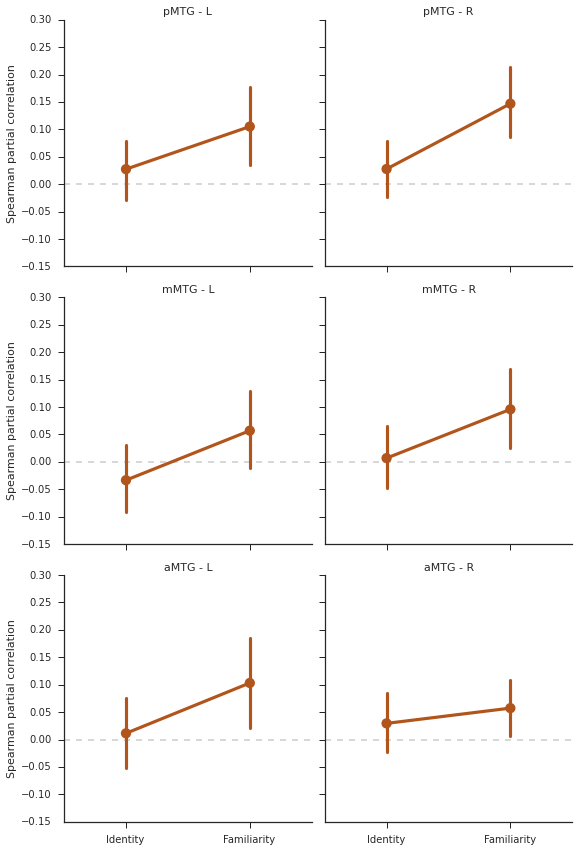

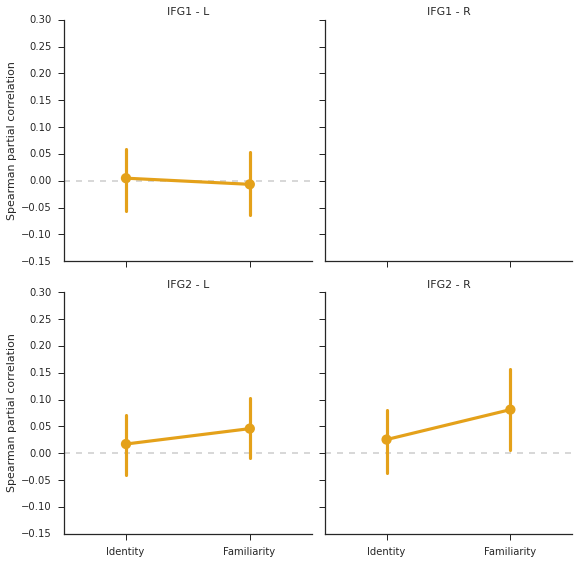

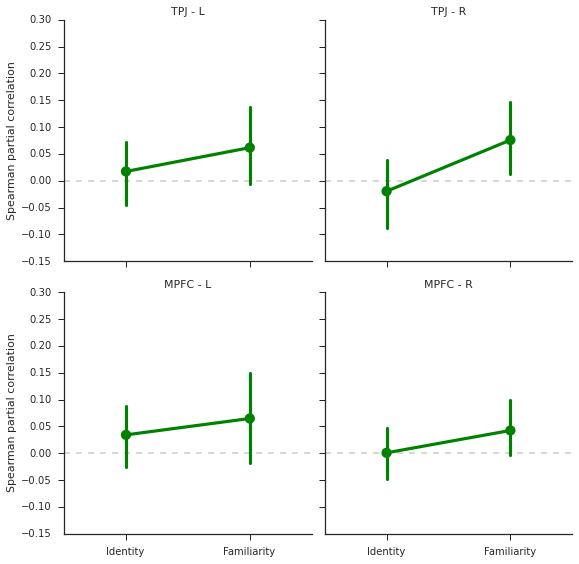

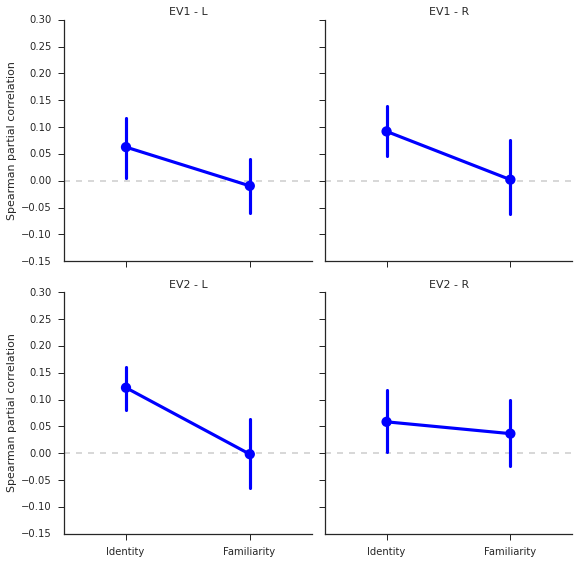

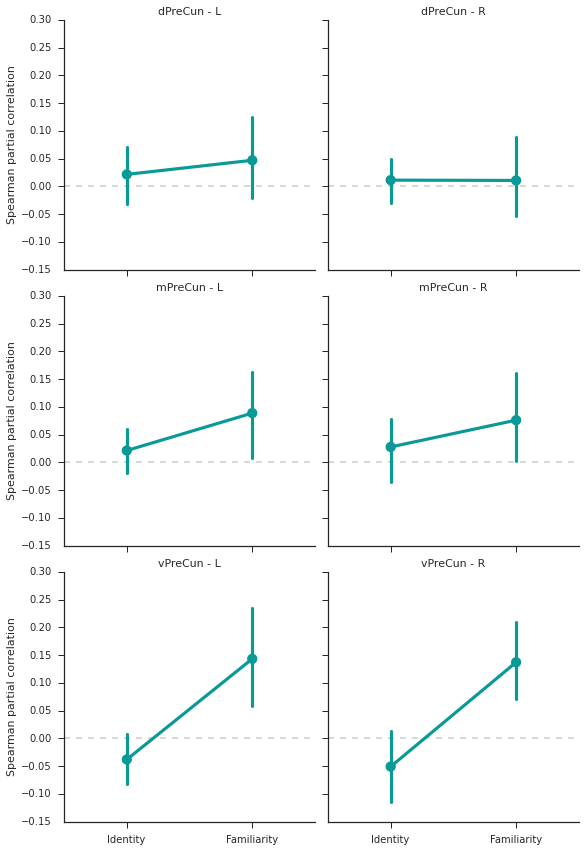

In [30]:
# finally plot for each system
save = True
for system, df in df_systems.iteritems():
    g = sns.factorplot(x='variable', y='value', col='side', row='roi', 
               col_order=['L', 'R'], 
               row_order=system2order[system],
               data=df,
               kind='point', color=system2color[system])
    g.map(plt.axhline, color='lightgray', linestyle='dashed', zorder=0)
    g.set_axis_labels(x_var='', y_var='Spearman partial correlation')
    g.set_titles('{row_name} - {col_name}')
    g.set_xticklabels(['Identity', 'Familiarity'])
    g.set(ylim=(-0.15, 0.3))
    if save:
        g.savefig(pjoin(img_dir, 'modelrsa_{0}.png'.format(system)), dpi=300)

Add system label to `corr_rois_df_long` so that we can plot within each system

In [31]:
corr_rois_df_long['system'] = map(lambda x: roi2system[x], corr_rois_df_long['roi'])

In [32]:
system_order = [
     'early_visual', 
     'ventral_core_system',
     'dorsal_core_system',
     'anterior_core_system',
     'theory_of_mind',
     'precuneus']

In [33]:
df_avgroi = corr_rois_df_long.groupby(['subject', 'variable', 'side', 'system']).mean().reset_index()

In [34]:
df_avgroi['side_lbl'] = ['Left' if s == 'L' else 'Right' for s in df_avgroi.side]
df_avgroi['variable_lbl'] = [v.title() for v in df_avgroi.variable]

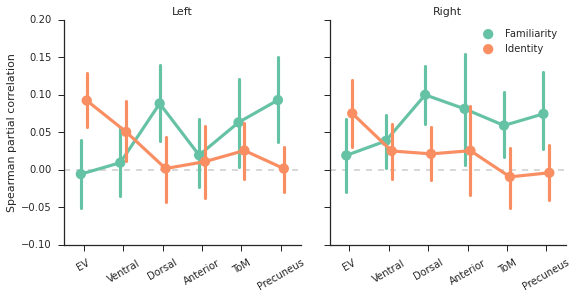

In [35]:
g = sns.factorplot(x='system', y='value', col='side_lbl', 
                   hue='variable_lbl', kind='point', order=system_order,
                   data=df_avgroi, dodge=0.15, palette='Set2',
                   legend=False)
g.map(plt.axhline, color='lightgray', linestyle='dashed', zorder=0)
g.set_titles('{col_name}')
g.set_axis_labels(x_var='', y_var='Spearman partial correlation')
g.set_xticklabels(['EV', 'Ventral', 'Dorsal', 'Anterior', 'ToM', 'Precuneus'], rotation=30)
g.axes[0][1].legend(loc=0)
if save:
    g.savefig(pjoin(img_dir, 'modelrsa_avgsystem.png'), dpi=300)

In [36]:
# plot also C1, C2 as control
corr_rois_c1c2 = pd.melt(corr_rois_df, value_vars=['c1', 'c2'], 
                            id_vars=['index', 'subject'])
# add side and roi for plotting with factorplot
corr_rois_c1c2['side'] = map(lambda x: x.split(' - ')[1], corr_rois_c1c2['index'])
corr_rois_c1c2['roi'] = map(lambda x: x.split(' - ')[0], corr_rois_c1c2['index'])
corr_rois_c1c2['system'] = map(lambda x: roi2system[x], corr_rois_c1c2['roi'])
df_avgroi_c1c2 = corr_rois_c1c2.groupby(['subject', 'variable', 'side', 'system']).mean().reset_index()
df_avgroi_c1c2['side_lbl'] = ['Left' if s == 'L' else 'Right' for s in df_avgroi_c1c2.side]
df_avgroi_c1c2['variable_lbl'] = [v.title() for v in df_avgroi_c1c2.variable]

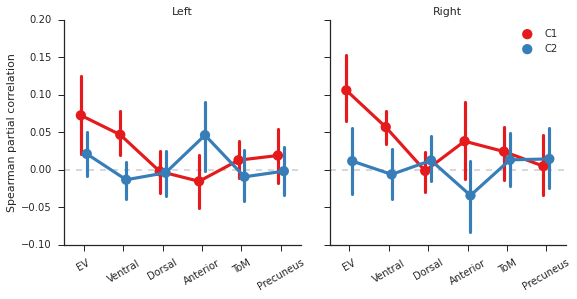

In [37]:
g = sns.factorplot(x='system', y='value', col='side_lbl', 
                   hue='variable_lbl', kind='point', order=system_order,
                   data=df_avgroi_c1c2, dodge=0.15, palette='Set1',
                   legend=False)
g.map(plt.axhline, color='lightgray', linestyle='dashed', zorder=0)
g.set_titles('{col_name}')
g.set_axis_labels(x_var='', y_var='Spearman partial correlation')
g.set_xticklabels(['EV', 'Ventral', 'Dorsal', 'Anterior', 'ToM', 'Precuneus'], rotation=30)
g.axes[0][1].legend(loc=0)
if save:
    g.savefig(pjoin(img_dir, 'modelrsa_c1c2_avgsystem.png'), dpi=300)